In [235]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import community  # louvain
from collections import defaultdict
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from infomap import Infomap
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from community import community_louvain
import cvxpy as cp

In [236]:
df = pd.read_csv('/Users/soniaborsi/Desktop/sp500_stocks.csv')

In [237]:
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,MMM,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,MMM,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,MMM,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,MMM,NaN,NaN,NaN,NaN,NaN,NaN


In [238]:
len(df)

1891536

In [239]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,617831.000000,617831.000000,617831.000000,617831.000000,617831.000000,6.178310e+05
mean,79.672357,87.471540,88.417844,86.480997,87.460302,9.347125e+06
std,102.742931,104.521901,105.684113,103.300770,104.519845,4.771669e+07
min,0.203593,0.222000,0.226250,0.216250,0.218000,0.000000e+00
25%,26.572459,32.700001,33.060001,32.299999,32.689999,1.144000e+06
50%,49.821613,59.139999,59.720001,58.500000,59.119999,2.453400e+06
75%,94.831036,105.019997,106.129997,103.889999,105.000000,5.657850e+06
max,1702.530029,1702.530029,1714.750000,1696.900024,1706.400024,3.692928e+09


In [240]:
df.shape

(1891536, 8)

In [241]:
df.columns

Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891536 entries, 0 to 1891535
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date       object 
 1   Symbol     object 
 2   Adj Close  float64
 3   Close      float64
 4   High       float64
 5   Low        float64
 6   Open       float64
 7   Volume     float64
dtypes: float64(6), object(2)
memory usage: 115.5+ MB


In [243]:
print(df.isnull().sum())

Date               0
Symbol             0
Adj Close    1273705
Close        1273705
High         1273705
Low          1273705
Open         1273705
Volume       1273705
dtype: int64


In [244]:
# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

In [245]:
# Drop duplicate rows (if any)
df = df.drop_duplicates()

In [246]:
stocks_df = df.dropna(subset=["Adj Close", "Close", "High", "Low", "Open"], how='all')
stocks_df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
3768,2010-01-04,AOS,5.937266,7.435000,7.480000,7.261667,7.295000,1104600.0
3769,2010-01-05,AOS,5.861404,7.340000,7.431667,7.308333,7.431667,1207200.0
3770,2010-01-06,AOS,5.864068,7.343333,7.405000,7.301667,7.335000,663000.0
3771,2010-01-07,AOS,5.881369,7.365000,7.425000,7.311667,7.356667,564000.0
3772,2010-01-08,AOS,5.967879,7.473333,7.485000,7.311667,7.331667,504600.0


In [247]:
len(stocks_df)

617831

In [248]:
stocks_df['Symbol'].unique()

array(['AOS', 'ABT', 'ABBV', 'AES', 'ALB', 'ALLE', 'ALL', 'GOOG', 'MO',
       'AMZN', 'AXP', 'AMP', 'APH', 'ANSS', 'ADM', 'ANET', 'AJG', 'T',
       'AXON', 'BKR', 'BAX', 'BDX', 'BBY', 'BK', 'BWA', 'BSX', 'BRO',
       'BLDR', 'COF', 'KMX', 'CCL', 'CAT', 'CE', 'CVX', 'CSCO', 'C',
       'CLX', 'CME', 'CMCSA', 'ED', 'STZ', 'GLW', 'CSGP', 'DE', 'DELL',
       'DXCM', 'DLR', 'DFS', 'DG', 'DPZ', 'DOV', 'DHI', 'DTE', 'EMN',
       'EIX', 'EA', 'ENPH', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL',
       'EXPE', 'FFIV', 'FDS', 'FAST', 'FRT', 'FDX', 'FSLR', 'FTNT',
       'FOXA', 'FOX', 'BEN', 'FCX', 'GIS', 'GPN', 'GDDY', 'HIG', 'HCA',
       'HSIC', 'HPE', 'HLT', 'HRL', 'HST', 'HII', 'IEX', 'INCY', 'IR',
       'PODD', 'ICE', 'IFF', 'IP', 'ISRG', 'INVH', 'IQV', 'IRM', 'JBHT',
       'JCI', 'K', 'KIM', 'LH', 'LRCX', 'LEN', 'LKQ', 'MCD', 'MRK',
       'META', 'MTD', 'MSFT', 'MSI', 'NDAQ', 'NTAP', 'NFLX', 'NVDA',
       'OMC', 'ON', 'ORCL', 'PKG', 'PARA', 'PH', 'PAYX', 'PEP', 'PM',
       'PNW', '

In [249]:
df['Date'].min()

Timestamp('2010-01-04 00:00:00')

In [250]:
df['Date'].max()

Timestamp('2024-12-20 00:00:00')

In [251]:
# dates as index and stock symbols as columns
stock_prices = stocks_df.pivot(index="Date", columns="Symbol", values="Adj Close")

### Log Returns

In [252]:
returns = stock_prices.apply(lambda x: np.log(x) - np.log(x.shift(1)))
returns.head()

Symbol,ABBV,ABT,ADM,AES,AJG,ALB,ALL,ALLE,AMP,AMZN,...,VRTX,VTRS,WDC,WEC,WELL,WMB,WRB,WST,WTW,XYL
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,-0.008112,0.005388,-0.010294,-0.005388,-0.001840,0.016308,NaN,0.023053,0.005883,...,-0.033559,-0.010741,0.026168,-0.013157,0.013979,0.012416,-0.003679,-0.012749,-0.002243,NaN
2010-01-06,NaN,0.005538,-0.002532,-0.010402,0.000450,0.001840,0.000323,NaN,0.013870,-0.018282,...,-0.017687,-0.009767,0.000860,0.010136,-0.004938,0.031934,0.002045,-0.009799,0.015970,NaN
2010-01-07,NaN,0.008250,-0.010511,0.000747,-0.006321,-0.007114,0.005161,NaN,0.007463,-0.017160,...,-0.012690,-0.017047,-0.019764,-0.002019,0.002023,-0.007107,0.004079,0.003105,-0.002952,NaN
2010-01-08,NaN,0.005099,-0.012567,0.027964,0.002714,0.014959,0.004174,NaN,0.003592,0.026717,...,-0.020203,-0.034418,0.005032,0.005843,-0.010384,0.007993,-0.000814,-0.000259,-0.001110,NaN


In [253]:
returns.isna().sum().sum()

30437

In [254]:
# % of missing by ticker
na_ratio = returns.isna().mean().sort_values(ascending=False)

# look at the top offenders
print(na_ratio.head(10))

Symbol
SOLV    0.951168
VLTO    0.918790
UBER    0.624735
FOX     0.613854
FOXA    0.613588
IR      0.491773
INVH    0.473195
DELL    0.442675
HPE     0.387208
GDDY    0.350053
dtype: float64


In [255]:
# Drop the first row
returns = returns.iloc[1:]

In [256]:
mask = returns.isna().mean() < 0.30   # keep tickers with ≥70 % data
returns = returns.loc[:, mask]

In [257]:
returns = returns.ffill().bfill()

In [258]:
# drop remaining nans
returns = returns.dropna(axis=0, how='any')

In [259]:
print("Remaining NaNs:", returns.isna().sum().sum())
# should be 0 or very small (early delistings you decided to keep)

Remaining NaNs: 0


In [260]:
# outlier check
for col in returns.columns:
    lower_q = returns[col].quantile(0.01)
    upper_q = returns[col].quantile(0.99)
    returns[col] = np.clip(returns[col], lower_q, upper_q)

In [261]:
returns.head()
returns.to_csv("returns.csv", index=False)

In [262]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3767 entries, 2010-01-05 to 2024-12-20
Columns: 161 entries, ABBV to XYL
dtypes: float64(161)
memory usage: 4.7 MB


In [263]:
returns.index.name = "Date"

# Save to CSV
returns.to_csv("data/returns.csv") 

In [264]:
a = pd.read_csv('returns.csv')

In [265]:
a.isna().sum().sum()

0

### Correlation

In [266]:
corr_matrix = returns.corr()
corr_matrix.head()

Symbol,ABBV,ABT,ADM,AES,AJG,ALB,ALL,ALLE,AMP,AMZN,...,VRTX,VTRS,WDC,WEC,WELL,WMB,WRB,WST,WTW,XYL
Symbol,,,,,,,,,,,,,,,,,,,,,
ABBV,1.000000,0.409362,0.259931,0.196225,0.320026,0.161140,0.265445,0.322852,0.298359,0.194319,...,0.337711,0.318711,0.196683,0.204866,0.185216,0.242343,0.266621,0.279162,0.268092,0.055473
ABT,0.409362,1.000000,0.351381,0.336996,0.473505,0.309248,0.396095,0.172334,0.460894,0.375083,...,0.401425,0.380622,0.301861,0.350654,0.276259,0.288778,0.379226,0.486955,0.410403,0.280039
ADM,0.259931,0.351381,1.000000,0.442845,0.412044,0.418582,0.460665,0.154599,0.545821,0.272393,...,0.257106,0.370736,0.352815,0.318474,0.352685,0.439673,0.465819,0.307219,0.377208,0.268313
AES,0.196225,0.336996,0.442845,1.000000,0.410578,0.417174,0.412844,0.155462,0.486966,0.286595,...,0.231323,0.336679,0.344452,0.456268,0.436625,0.444443,0.404591,0.319178,0.358803,0.253404
AJG,0.320026,0.473505,0.412044,0.410578,1.000000,0.360201,0.559899,0.188531,0.601982,0.344909,...,0.335677,0.353148,0.345024,0.358817,0.388801,0.371803,0.623531,0.424860,0.662985,0.312280


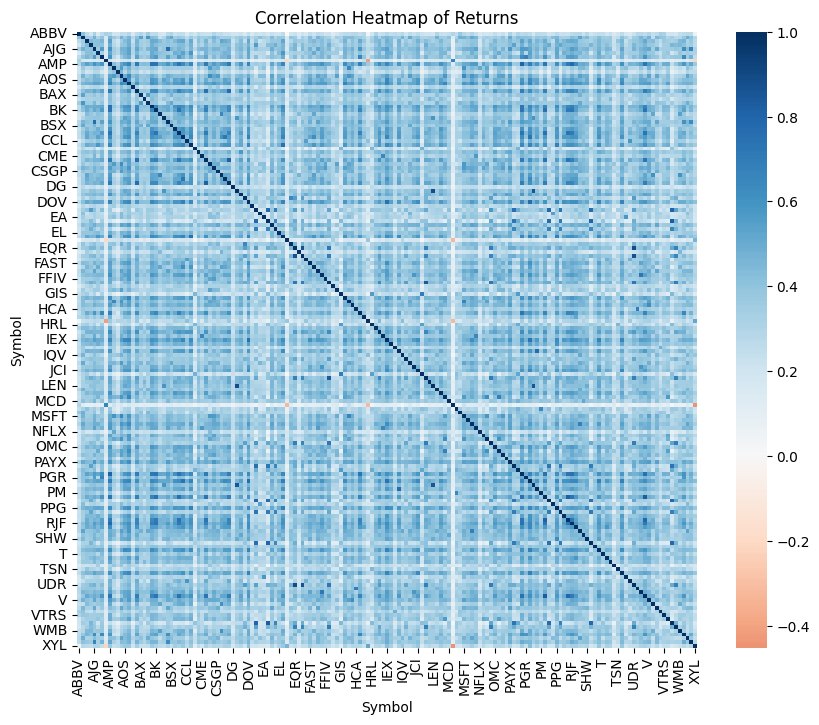

In [267]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='RdBu', center=0)
plt.title("Correlation Heatmap of Returns")
plt.show()

1) Threshold Graph

In [268]:
# 2) Fixed threshold
threshold = 0.3

# 3) Build a threshold graph in networkx
symbols = corr_matrix.columns
G_threshold = nx.Graph()

for i, sym_i in enumerate(symbols): 
    for j, sym_j in enumerate(symbols):
        if j <= i:
            continue  # avoid duplicate edges i->j, j->i
        if abs(corr_matrix.iloc[i, j]) >= threshold:
            # Add an edge with weight = correlation (or distance)
            G_threshold.add_edge(sym_i, sym_j, weight=corr_matrix.iloc[i, j])

print(f"Threshold graph has {G_threshold.number_of_nodes()} nodes and {G_threshold.number_of_edges()} edges.")

Threshold graph has 161 nodes and 9049 edges.


In [269]:
# Base threshold
base_threshold = 0.3

# Compute the average volatility across stocks for the current period (standard deviation for each stock and then take the average)
avg_volatility = returns.std().mean()

# Define a volatility scaling factor 
volatility_factor = 10.0

# Compute the dynamic threshold  (during high volatility threshold increases to filter noise)
dynamic_threshold = base_threshold * (1 + volatility_factor * avg_volatility)
print("Dynamic Threshold:", dynamic_threshold)

# Build a threshold graph in networkx using the dynamic threshold
symbols = corr_matrix.columns
G_threshold = nx.Graph()

for i, sym_i in enumerate(symbols): 
    for j, sym_j in enumerate(symbols):
        if j <= i:
            continue  # avoid duplicate edges
        if abs(corr_matrix.iloc[i, j]) >= dynamic_threshold:
            # Add an edge with the correlation as the weight
            G_threshold.add_edge(sym_i, sym_j, weight=corr_matrix.iloc[i, j])

print(f"Dynamic Threshold Graph has {G_threshold.number_of_nodes()} nodes and {G_threshold.number_of_edges()} edges.")

Dynamic Threshold: 0.35148729063666984
Dynamic Threshold Graph has 161 nodes and 6828 edges.


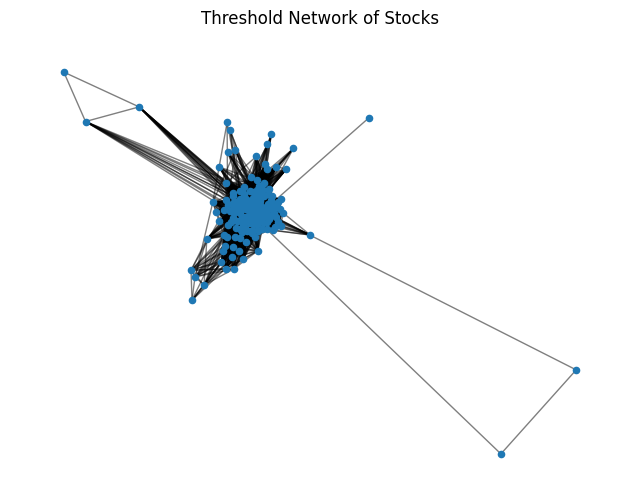

In [270]:
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_threshold, k=0.15)  # layout
nx.draw_networkx_nodes(G_threshold, pos, node_size=20)
nx.draw_networkx_edges(G_threshold, pos, alpha=0.5)
# nx.draw_networkx_labels(G_threshold, pos)  # if you really need stock labels
plt.title("Threshold Network of Stocks")
plt.axis("off")
plt.show()


2) Minimum Spanning Tree (MST)



In [271]:
symbols = corr_matrix.columns.tolist()

# Convert correlation to distance 
dist_matrix = np.sqrt(2*(1 - corr_matrix.clip(-0.999999, 0.999999)))

# # Build graph with distances as weights
G_complete = nx.Graph()
for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        G_complete.add_edge(symbols[i], symbols[j], weight=dist_matrix.iloc[i, j])

# 3) Compute the MST
mst = nx.minimum_spanning_tree(G_complete, weight='weight')

print(f"MST has {mst.number_of_nodes()} nodes and {mst.number_of_edges()} edges.")




MST has 161 nodes and 160 edges.


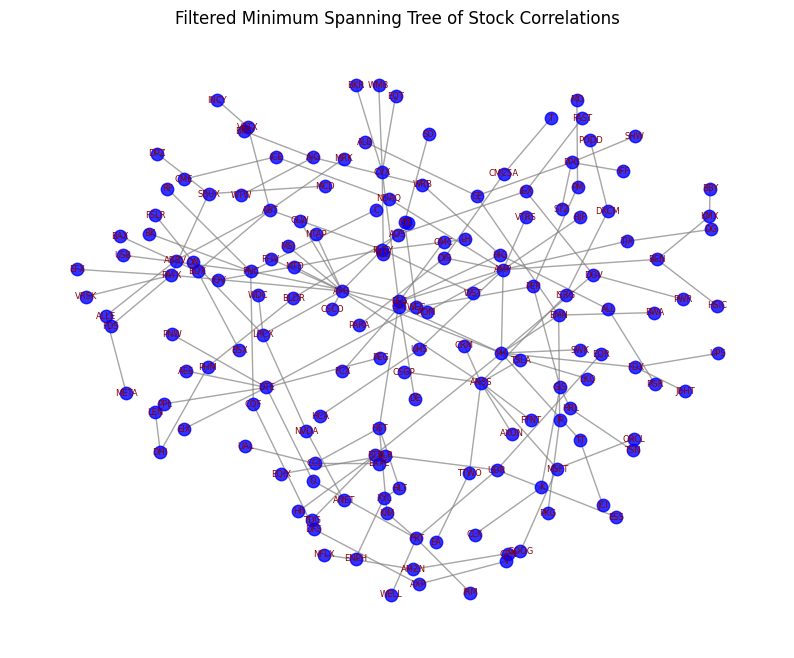

In [272]:
pos = nx.spring_layout(mst, k=0.25, seed=42)
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(mst, pos, node_size=80, node_color='blue', alpha=0.8)
nx.draw_networkx_edges(mst, pos, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(mst, pos, font_size=6, font_color='darkred')
plt.title("Filtered Minimum Spanning Tree of Stock Correlations")
plt.axis("off")
plt.show()


### Maximally Planar Filtered Graph (MPFG)

In [ ]:
# Create a complete weighted graph from distance matrix
def create_weighted_graph(dist_matrix):
    G = nx.Graph()
    for i in dist_matrix.index:
        for j in dist_matrix.columns:
            if i != j:
                G.add_edge(i, j, weight=dist_matrix.loc[i, j])
    return G

# Extract Maximally Planar Filtered Graph (MPFG)
def build_mpfg(G):
    # Sort edges by increasing weight (i.e., strongest correlation first)
    edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    
    P = nx.Graph()
    P.add_nodes_from(G.nodes())

    for u, v, data in edges:
        P.add_edge(u, v, weight=data['weight'])
        if not nx.check_planarity(P)[0]:
            P.remove_edge(u, v)
    return P

def draw_graph(G, title="Maximally Planar Filtered Graph"):
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 8))
    nx.draw(
        G,
        pos,
        with_labels=False,              # <-- Remove labels
        node_size=100,                  # <-- Smaller nodes
        node_color='skyblue',
        edge_color='gray',
        alpha=0.8
    )
    plt.title(title)
    plt.axis('off')
    plt.show()


G_full = create_weighted_graph(dist_matrix)
mpfg = build_mpfg(G_full)

# Visualize the MPFG
draw_graph(mpfg, "Maximally Planar Filtered Graph")


# Community detection

## Community detection threshold network

In [ ]:
# Louvain partitioning
partition = community.best_partition(G_threshold)

In [ ]:
mod_value = community.modularity(partition, G_threshold)
print("Louvain partition modularity:", mod_value)

In [ ]:
# partition[node] = community_id
community_ids = set(partition.values())
num_communities = len(community_ids)
num_communities

In [ ]:
comm_dict_threshold = defaultdict(list)
for node, comm_id in partition.items():
    comm_dict_threshold[comm_id].append(node)

# Now comm_dict[0] is the list of stocks in community 0, etc.
for c_id, members in comm_dict_threshold.items():
    print(f"Community {c_id} has {len(members)} nodes:", members)

In [ ]:
# nodes_g_threshold = list(G_threshold.nodes())  # Or pmfg_graph, but be consistent across methods
# louvain_labels_nodes_g_threshold = np.array([partition[n] for n in nodes_g_threshold])
# louvain_labels_nodes_g_threshold

## Community detection MST

In [ ]:
# Louvain partitioning
partition = community.best_partition(mst)
# partition

In [ ]:
mod_value = community.modularity(partition, mst)
print("Louvain partition modularity:", mod_value)

In [ ]:
comm_dict_mst = defaultdict(list)
for node, comm_id in partition.items():
    comm_dict_mst[comm_id].append(node)

for c_id, members in comm_dict_mst.items():
    print(f"Community {c_id} has {len(members)} nodes:", members)

## Community detection PMFG

In [ ]:
# Louvain partitioning
partition = community.best_partition(mpfg)
# partition

In [ ]:
mod_value = community.modularity(partition, mst)
print("Louvain partition modularity:", mod_value)

In [ ]:
comm_dict_mst = defaultdict(list)
for node, comm_id in partition.items():
    comm_dict_mst[comm_id].append(node)

for c_id, members in comm_dict_mst.items():
    print(f"Community {c_id} has {len(members)} nodes:", members)

### Sector Analysis

In [ ]:
# 1) Flatten the communities dict
rows = []
for cid, tickers in comm_dict_mst.items():
    for t in tickers:
        rows.append({'Symbol': t, 'Community': cid})
comm_df = pd.DataFrame(rows)

In [ ]:
returns = pd.read_csv("data/returns.csv", index_col=0)   # shape: T×N
sectors = pd.read_csv("data/sp500_companies.csv")   

In [ ]:
df = (
    comm_df
    .merge(sectors[['Symbol','Sector']], on='Symbol', how='left')
)

In [ ]:
# 3) Count by community & sector
counts = df.groupby(['Community','Sector']).size().unstack(fill_value=0)
props  = counts.div(counts.sum(axis=1), axis=0)  # proportions

print("Absolute counts:\n", counts)
print("\nProportions:\n", props)

# 4) Plot proportions as a stacked bar
props.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6)
)
plt.ylabel('Proportion of community')
plt.title('Sector composition by Louvain community')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def evaluate_purity(props_df):
    # props_df: communities × sectors (proportions, sums to 1 per row)
    purities = props_df.max(axis=1)          # each community’s single top‐sector share
    return purities, purities.mean()         # series + overall average

# props1, props2 are your two “Proportions” tables from correlation vs embeddings
pur1, avg1 = evaluate_purity(props)

print(f"Avg sector‐purity (corr‐graph): {avg1:.3f}")


### Strategy

NB: I choose MST because of the higher Louvain partition modularity: 0.913291159383378 (this could be further explored)

In [ ]:
####################################
# 1: Basic Markowitz MPT
####################################
def markowitz_optimize(returns_df, lam=1.0):
    """
    Solves a simple mean-variance Markowitz optimization:
    minimize w^T Sigma w - lam * w^T mu
    subject to sum(w) = 1 and w >= 0.
    
    returns_df : DataFrame of daily returns, shape (dates, stocks)
    lam        : float, risk-aversion parameter
    returns w  : 1D np.array of optimal weights
    """
    # Drop any stocks with all nan or insufficient data
    returns_df = returns_df.dropna(axis=1, how='all')
    # If fewer than 2 stocks remain, just return equal weighting
    if returns_df.shape[1] < 2:
        n = returns_df.shape[1]
        return np.ones(n) / max(n, 1)

    mu = returns_df.mean().values      # expected returns (average of historical)
    Sigma = returns_df.cov().values    # covariance matrix
    n = len(mu)

    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma) - lam * (mu @ w))
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=False, warm_start=True)
    
    if w.value is None:
        # Optimization failed, fallback to equal weighting
        return np.ones(n) / n
    else:
        return w.value

In [ ]:
####################################
# 2: Compute daily portfolio returns
####################################
def portfolio_returns(weights_dict, returns_df):
    """
    weights_dict: {stock: weight} for the portfolio
    returns_df: DataFrame with columns = stocks, index = dates
    returns a Series with daily returns of the portfolio
    """
    # Align columns 
    all_stocks = [s for s in weights_dict if s in returns_df.columns]
    w_series = pd.Series({s: weights_dict[s] for s in all_stocks})
    w_series = w_series.reindex(returns_df.columns, fill_value=0.0)
    
    daily_rets = returns_df.dot(w_series)  # row-wise dot product
    return daily_rets


In [ ]:
####################################
# 3: Evaluate performance
####################################
def evaluate_performance(port_rets):
    """
    Returns a dict of metrics: annualized return, annualized vol, Sharpe, etc.
    """
    avg_ret = port_rets.mean()      # daily average
    vol = port_rets.std()           # daily stdev
    
    ann_ret = (1 + avg_ret)**252 - 1  # annualized (252 trading days per year)
    ann_vol = vol * np.sqrt(252)
    sharpe = 0 if ann_vol == 0 else ann_ret / ann_vol
    return {
        "annual_return": ann_ret,
        "annual_vol": ann_vol,
        "sharpe": sharpe
    }

In [ ]:
all_comm_results = {}  # store performance

for comm_id, comm_stocks in comm_dict_mst.items():
    # Slice returns for these stocks
    sub_returns = returns[comm_stocks].dropna(how='all', axis=1)
    if sub_returns.shape[1] == 0:
        print(f"No valid data for community {comm_id}; skipping.")
        continue
    
    # Markowitz optimization
    w_opt = markowitz_optimize(sub_returns, lam=1.0)
    # dict {stock: weight}
    markowitz_weights = dict(zip(sub_returns.columns, w_opt))
    port_ret_mkv = portfolio_returns(markowitz_weights, sub_returns)
    perf_mkv = evaluate_performance(port_ret_mkv)

    # Equally Weighted
    n_stocks = sub_returns.shape[1]
    ew_weights = {s: 1.0 / n_stocks for s in sub_returns.columns}
    port_ret_ew = portfolio_returns(ew_weights, sub_returns)
    perf_ew = evaluate_performance(port_ret_ew)

    all_comm_results[comm_id] = {
        "stocks": sub_returns.columns.tolist(),
        "markowitz_weights": markowitz_weights,
        "markowitz_perf": perf_mkv,
        "ew_weights": ew_weights,
        "ew_perf": perf_ew
    }

In [ ]:
all_comm_results.keys()

In [ ]:
def top_k_central_stocks(mst, comm_stocks, k=5):
    subg = mst.subgraph(comm_stocks)
    # eigenvector centrality
    cvals = nx.eigenvector_centrality(subg, weight='weight', max_iter=500)
    sorted_stocks = sorted(cvals.keys(), key=lambda s: cvals[s], reverse=False)
    return sorted_stocks[:k]

In [ ]:
k = 5  
top_central_dict = {} 

for c_id, comm_stocks in comm_dict_mst.items():
    if len(comm_stocks) == 0:
        top_central_dict[c_id] = []
    else:
        top_central_dict[c_id] = top_k_central_stocks(mst, comm_stocks, k=k)

# Combine all top central stocks from all communities
all_central_stocks = set()
for c_id, c_stocks in top_central_dict.items():
    all_central_stocks.update(c_stocks)
all_central_stocks = list(all_central_stocks)

In [ ]:
central_returns = returns[all_central_stocks].dropna(how='all', axis=1)

# A) Markowitz
w_opt_central = markowitz_optimize(central_returns, lam=1.0)
mw_port = dict(zip(central_returns.columns, w_opt_central))
mw_ret_series = portfolio_returns(mw_port, central_returns)
mw_perf = evaluate_performance(mw_ret_series)

# B) Equal-weight among top-central stocks
n_central = len(central_returns.columns)
ew_port = {s: 1.0/n_central for s in central_returns.columns}
ew_ret_series = portfolio_returns(ew_port, central_returns)
ew_perf = evaluate_performance(ew_ret_series)

In [ ]:
print("=== Central-Stocks Markowitz Performance ===")
print(mw_perf)
print("=== Central-Stocks Equal-Weight Performance ===")
print(ew_perf)

In [ ]:
# Print community-level stats
for comm_id, res in all_comm_results.items():
    print(f"\n=== Community {comm_id} ===")
    print(f"Stocks: {res['stocks']}")
    print("Markowitz Perf:", res['markowitz_perf'])
    print("Equal-Weight Perf:", res['ew_perf'])

In [ ]:
# Print the aggregated "central" portfolio stats
print("\n=== Central Stocks Portfolio ===")
print("Markowitz:", mw_perf)
print("Equal-Weight:", ew_perf)

### strategy evaluation 

In [273]:
def build_mst_and_partition(returns_window):
    """
    1) Clean returns_window by dropping NaNs
    2) Compute correlation
    3) Convert to distance
    4) Build MST
    5) Partition with Louvain
    Returns: (mst_graph, partition_dict)
    """
    # Drop stocks with any NaNs
    clean_data = returns_window.dropna(axis=1, how='any')

    if clean_data.shape[1] < 2:
        raise ValueError("Not enough valid stocks after dropping NaNs")

    # 1) correlation
    corr_matrix = clean_data.corr()

    # 2) distance (clip to avoid sqrt of negative)
    dist_matrix = np.sqrt(2 * (1 - corr_matrix.clip(-0.999999, 0.999999)))

    # 3) build complete graph
    symbols = dist_matrix.columns.tolist()
    G_complete = nx.Graph()
    for i in range(len(symbols)):
        for j in range(i + 1, len(symbols)):
            weight = dist_matrix.iloc[i, j]
            if np.isnan(weight):
                continue  # skip NaN weights
            G_complete.add_edge(symbols[i], symbols[j], weight=weight)

    # 4) minimum spanning tree
    mst = nx.minimum_spanning_tree(G_complete, weight='weight')

    # 5) Louvain partition
    partition_dict = community_louvain.best_partition(mst, weight='weight')

    return mst, partition_dict


In [274]:
def rolling_backtest(returns, L=252, H=21):
    """
    returns: DataFrame (date x stocks), daily freq
    L: training window size (#days)
    H: hold period (#days)
    """

    # 1) define rebalancing dates
    all_dates = returns.index.sort_values()
    start_idx = 0
    # we start rebalancing once we have at least L days of data
    # so the earliest rebalance date is all_dates[L]
    # then step by H each time
    # store portfolio returns out-of-sample for each rebal
    strategy_returns = []
    partitions_store = {} 

    # find the first valid rebal index = L
    # then step by H
    t_idx_list = []
    i = L
    while i < len(all_dates):
        t_idx_list.append(i)
        i += H

    for i_reb in t_idx_list:
        reb_date = all_dates[i_reb]  # actual timestamp
        # training window = [reb_date-L, reb_date-1]
        train_start = i_reb - L
        train_end   = i_reb - 1
        if train_start < 0:
            continue
        
        train_dates = all_dates[train_start : i_reb]  # i_reb is excluded
        window_data = returns.loc[train_dates]
        # 2) build MST + partition
        mst_graph, partition = build_mst_and_partition(window_data)
        
        # 3) final portfolio 
        #    build a single Markowitz portfolio
        #    using the top-k central stocks across ALL communities 
        
        # A) create comm_dict from partition
        comm_dict = defaultdict(list)
        for node, comm_id in partition.items():
            comm_dict[comm_id].append(node)
        
        # pick top central nodes from each community
        top_central = []
        for c_id, c_stocks in comm_dict.items():
            sub_top = top_k_central_stocks(mst_graph, c_stocks, k=5)
            top_central.extend(sub_top)
        top_central = list(set(top_central))  # unify

        # Markowitz on top_central
        sub_ret = window_data[top_central]
        w_opt = markowitz_optimize(sub_ret, lam=1.0)
        weights_dict = dict(zip(sub_ret.columns, w_opt))

        # 4) out-of-sample daily returns from reb_date up to reb_date+H-1
        test_start_idx = i_reb
        test_end_idx   = min(i_reb + H, len(all_dates))  
        test_dates = all_dates[test_start_idx : test_end_idx]
        test_data = returns.loc[test_dates, top_central]
        daily_rets = portfolio_returns(weights_dict, test_data)

        strategy_returns.append(daily_rets)
        partitions_store[reb_date] = partition  # to track partition over time

    # combine all out-of-sample returns
    if len(strategy_returns) > 0:
        strategy_returns = pd.concat(strategy_returns, axis=0).sort_index()
    else:
        strategy_returns = pd.Series(dtype=float)

    return strategy_returns, partitions_store


In [275]:
def rolling_backtest_equal_weight(returns, L=252, H=21):
    """
    A baseline: invests equally in all stocks that exist in the training window.
    Then hold that for the next H days out-of-sample.
    """
    all_dates = returns.index.sort_values()
    strategy_returns = []

    i = L
    while i < len(all_dates):
        # Rebalance date
        reb_date = all_dates[i]

        # Training window
        train_start = i - L
        train_end   = i
        train_dates = all_dates[train_start:train_end]
        window_data = returns.loc[train_dates]

        # Choose all columns with valid data in last window
        valid_stocks = window_data.dropna(axis=1, how='all').columns
        n_valid = len(valid_stocks)
        if n_valid == 0:
            # skip if no data
            i += H
            continue

        # Weights are 1/n for valid_stocks, 0 for others
        ew_weights = {s: 1.0/n_valid for s in valid_stocks}

        # Next H days out-of-sample
        test_start_idx = i
        test_end_idx   = min(i + H, len(all_dates))
        test_dates = all_dates[test_start_idx:test_end_idx]
        test_data = returns.loc[test_dates, valid_stocks]

        daily_rets = test_data.dot(pd.Series(ew_weights))
        strategy_returns.append(daily_rets)

        i += H  # move forward

    if len(strategy_returns) > 0:
        strategy_returns = pd.concat(strategy_returns, axis=0).sort_index()
    else:
        strategy_returns = pd.Series(dtype=float)
    return strategy_returns

In [289]:
def rolling_backtest_markowitz_all(returns, L=252, H=21, lam=1.0):
    """
    Rolling Markowitz on the entire 'valid' set of stocks each window.
    1) For each rebal date, take [i-L, i) as training
    2) Solve Markowitz (no community filtering).
    3) Next H days out-of-sample returns
    """
    all_dates = returns.index.sort_values()
    strategy_returns = []

    i = L
    while i < len(all_dates):
        reb_date = all_dates[i]
        # training window
        train_start = i - L
        train_end   = i
        train_dates = all_dates[train_start : train_end]
        window_data = returns.loc[train_dates]

        # pick stocks that have at least some data
        valid_stocks = window_data.dropna(axis=1, how='all').columns
        n_valid = len(valid_stocks)
        if n_valid < 2:
            i += H
            continue

        # Markowitz on all valid_stocks
        sub_ret = window_data[valid_stocks]
        if returns.shape[1] < 2:
            return np.ones(returns.shape[1]) / returns.shape[1]

        w_opt = markowitz_optimize(sub_ret, lam=lam)
        weights_dict = dict(zip(sub_ret.columns, w_opt))

        # out-of-sample
        test_start_idx = i
        test_end_idx   = min(i+H, len(all_dates))
        test_dates = all_dates[test_start_idx : test_end_idx]
        test_data = returns.loc[test_dates, valid_stocks]
        daily_rets = test_data.dot(pd.Series(weights_dict))

        strategy_returns.append(daily_rets)

        i += H  # move forward

    if len(strategy_returns) > 0:
        strategy_returns = pd.concat(strategy_returns, axis=0).sort_index()
    else:
        strategy_returns = pd.Series(dtype=float)

    return strategy_returns


In [281]:
def top_k_central_stocks(mst, comm_stocks, k=5):
    subg = mst.subgraph(comm_stocks)
    try:
        cvals = nx.eigenvector_centrality(subg, weight='weight', max_iter=500)
    except nx.PowerIterationFailedConvergence:
        print(f"[Warning] Eigenvector centrality failed for community of size {len(comm_stocks)}. Falling back to degree centrality.")
        cvals = nx.degree_centrality(subg)

    sorted_stocks = sorted(cvals.keys(), key=lambda s: cvals[s], reverse=True)
    return sorted_stocks[:k]


In [278]:
def rolling_backtest_random_community(returns, L=252, H=21, k=5, lam=1.0):
    """
    Rolling-window backtest using random selection from each detected community.
    
    Parameters:
        returns (pd.DataFrame): Daily returns with dates as index and stocks as columns.
        L (int): Training window size (number of days).
        H (int): Holding period (number of days) for each rebalancing.
        k (int): Number of stocks to randomly select per community.
        lam (float): Risk-aversion parameter for the Markowitz optimization.
        
    Returns:
        strategy_returns (pd.Series): Out-of-sample daily returns from all rebalancing periods.
        partitions_store (dict): Dictionary mapping each rebalancing date to its partition.
    """
    # 1) Define rebalancing dates (start after L days and then every H days)
    all_dates = returns.index.sort_values()
    strategy_returns = []
    partitions_store = {}

    t_idx_list = []
    i = L
    while i < len(all_dates):
        t_idx_list.append(i)
        i += H

    # 2) Loop over each rebalance index
    for i_reb in t_idx_list:
        reb_date = all_dates[i_reb]  # current rebalancing date
        
        # Training window: from (i_reb - L) to (i_reb - 1)
        train_dates = all_dates[i_reb - L : i_reb]
        window_data = returns.loc[train_dates]
        
        # 3) Build MST and detect communities
        mst_graph, partition = build_mst_and_partition(window_data)
        
        # 4) Group stocks by community
        comm_dict = defaultdict(list)
        for node, comm_id in partition.items():
            comm_dict[comm_id].append(node)
        
        # 5) Randomly select k stocks from each community
        random_selection = []
        for stocks in comm_dict.values():
            if len(stocks) <= k:
                # If the community has less than or equal to k stocks keep them all
                random_selection.extend(stocks)
            else:
                # Randomly select k stocks 
                selected = np.random.choice(stocks, size=k, replace=False).tolist()
                random_selection.extend(selected)
        random_selection = list(set(random_selection))
        
        # 6) Apply Markowitz optimization on the randomly selected stocks over the training window
        sub_ret = window_data[random_selection]
        w_opt = markowitz_optimize(sub_ret, lam=lam)
        weights_dict = dict(zip(sub_ret.columns, w_opt))
        
        # 7) Out-of-sample: compute daily portfolio returns from reb_date to reb_date + H - 1
        test_start_idx = i_reb
        test_end_idx = min(i_reb + H, len(all_dates))
        test_dates = all_dates[test_start_idx : test_end_idx]
        test_data = returns.loc[test_dates, random_selection]
        daily_rets = portfolio_returns(weights_dict, test_data)
        
        strategy_returns.append(daily_rets)
        partitions_store[reb_date] = partition 

    # Combine all out-of-sample returns into one series sorted by date
    if strategy_returns:
        strategy_returns = pd.concat(strategy_returns, axis=0).sort_index()
    else:
        strategy_returns = pd.Series(dtype=float)
        
    return strategy_returns, partitions_store


In [284]:
def markowitz_optimize(returns, lam=1.0):
    """
    Basic long-only Markowitz optimization:
    min w.T Σ w - λ w.T μ
    s.t. sum(w) = 1, w ≥ 0
    """
    import cvxpy as cp
    import numpy as np

    mu = returns.mean().values
    Sigma = returns.cov().values
    n = len(mu)

    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma) - lam * mu.T @ w)
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)

    try:
        result = prob.solve(solver=cp.OSQP, warm_start=True)
        if w.value is None:
            raise cp.SolverError("No solution found.")
        return np.array(w.value).flatten()
    except cp.SolverError:
        print("[Warning] Markowitz optimization failed, falling back to equal weights.")
        return np.ones(n) / n  # Equal weights fallback


Evaliuation and comparison with equal weight and full Markovitz 

In [282]:
# 1) Community-based approach
out_of_sample_returns_cb, partition_hist = rolling_backtest(returns, L=252, H=21)
cb_perf = evaluate_performance(out_of_sample_returns_cb)

In [291]:
# 2) Equal-weight approach
out_of_sample_returns_ew = rolling_backtest_equal_weight(returns, L=252, H=21)
ew_perf = evaluate_performance(out_of_sample_returns_ew)


In [292]:
# 4) Random per-community selection approach:
out_of_sample_returns_rand, partition_hist_rand = rolling_backtest_random_community(returns, L=252, H=21, k=5, lam=1.0)
rand_perf = evaluate_performance(out_of_sample_returns_rand)

In [293]:
print("Community-based Perf:", cb_perf)
print("Equal-weight Perf:", ew_perf)
# print("Full Markowitz Perf:", full_perf)
print("Random per-community Perf:", rand_perf)

Community-based Perf: {'annual_return': 0.2725851775126542, 'annual_vol': 0.40906810509061636, 'sharpe': 0.6663564675917997}
Equal-weight Perf: {'annual_return': 0.12857571425850822, 'annual_vol': 0.15959082990182946, 'sharpe': 0.805658535252935}
Random per-community Perf: {'annual_return': 0.2095811711773239, 'annual_vol': 0.40399235591427196, 'sharpe': 0.5187750909371104}


In [296]:
def format_perf(perf_dict):
    return {
        'annual_return': f"{perf_dict['annual_return'] * 100:.2f}%",
        'annual_vol': f"{perf_dict['annual_vol'] * 100:.2f}%",
        'sharpe': f"{perf_dict['sharpe']:.2f}"
    }

print("Community-based Perf:", format_perf(cb_perf))
print("Equal-weight Perf:", format_perf(ew_perf))
# print("Full Markowitz Perf:", format_perf(full_perf))
print("Random per-community Perf:", format_perf(rand_perf))

Community-based Perf: {'annual_return': '27.26%', 'annual_vol': '40.91%', 'sharpe': '0.67'}
Equal-weight Perf: {'annual_return': '12.86%', 'annual_vol': '15.96%', 'sharpe': '0.81'}
Random per-community Perf: {'annual_return': '20.96%', 'annual_vol': '40.40%', 'sharpe': '0.52'}


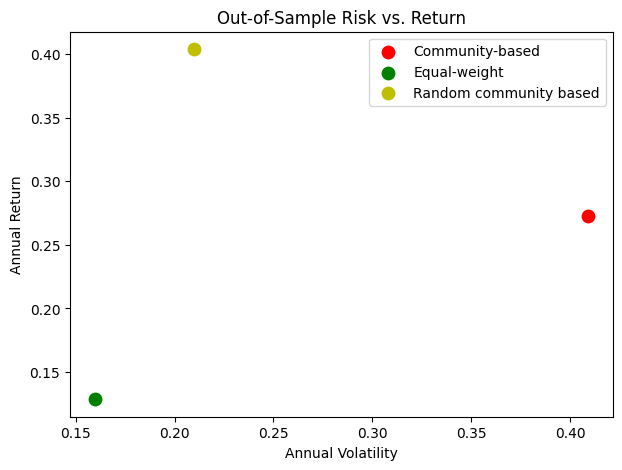

In [295]:
# from evaluate_performance(returns)
cb_ret = cb_perf['annual_return']
cb_vol = cb_perf['annual_vol']
ew_ret = ew_perf['annual_return']
ew_vol = ew_perf['annual_vol']
# full_ret = full_perf['annual_return']
# full_vol = full_perf['annual_vol']

random_ret = rand_perf['annual_return']
random_vol = rand_perf['annual_vol']

plt.figure(figsize=(7,5))
plt.scatter(cb_vol, cb_ret, c='r', s=80, label='Community-based')
plt.scatter(ew_vol, ew_ret, c='g', s=80, label='Equal-weight')
# plt.scatter(full_vol, full_ret, c='b', s=80, label='Full Markowitz')
plt.scatter(random_ret, random_vol, c='y', s=80, label='Random community based')
plt.xlabel("Annual Volatility")
plt.ylabel("Annual Return")
plt.title("Out-of-Sample Risk vs. Return")
plt.legend()
plt.show()